# Can we beat Welch's t-test?

The current version of this script is super-stupid. But to do any interesting research, you have to plant
a few small acorns, and this is the smallest of acorns.

Suppose you have to evaluate NUMBER_OF_EXPERIMENTS very small experiments. By a weird
coincidence, they all have the same number of participants. There are CONTROL_GROUP_SIZE patients
getting a placebo, and EXPERIMENT_GROUP_SIZE getting a drug.

Unfortunately approximately PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING of those drugs actually have no effect either.

You want to create a classifier to determine whether or not the experimental drug worked.

Also, amazingly, the control group and the experimental group metrics are normally distributed. 

You don't know the population mean or standard deviation: you don't know it for the control group 
and you don't know it for the experimental group.

You do know that the control group's standard deviation is somewhere between 
CONTROL_POPULATION_STDDEV_LOW and CONTROL_POPULATION_STDDEV_HIGH. You know this
because you know something about your field, it would be impossible for the standard deviation to be
outside of these bounds.

Obviously, the experiments where the drug is useless the experimental data will have the same mean and standard deviation as the controls.

In the experiments where the drug is useful, they differ. You don't know how much, but you can put some bounds
on it:

- the distribution of data from a successful experimental will have a mean within EXPERIMENTAL_MEAN_RANGE of
  the control group's mean
  
- the standard deviation will be between EXPERIMENTAL_STDDEV_LOW and EXPERIMENTAL_STDDEV_HIGH

-------

Being a well-trained statistician with years of experience, you use Welch's t-test.

Your offsider is a clueless data scientist whose sole training consisted of reading the sklearn documentation.

Who wins?

In [1]:
CONTROL_GROUP_SIZE=5
EXPERIMENT_GROUP_SIZE=6
PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=0.66
NUMBER_OF_EXPERIMENTS=1000000

CONTROL_POPULATION_STDDEV_LOW=1
CONTROL_POPULATION_STDDEV_HIGH=5

EXPERIMENTAL_MEAN_RANGE=10
EXPERIMENTAL_STDDEV_LOW=1
EXPERIMENTAL_STDDEV_HIGH=5

In [2]:
import scipy
import scipy.stats
import collections
import pandas
import numpy
import sklearn.model_selection
import sklearn.svm
import sklearn.dummy
import sklearn.metrics
import sklearn.tree
import sklearn.ensemble
import sklearn.neighbors

In [3]:
Experiment = collections.namedtuple("Experiment",
                                    ["ControlLoc", "ControlScale", "ControlValues",
                                     "ObservedControlMean", "ObservedControlStddev",
                                   "ExperimentLoc", "ExperimentScale", "ExperimentValues", 
                                   "ShouldShowResult"])

In [4]:
def generate_experiment():
    null_experiment = scipy.stats.uniform.rvs() <= PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING
    # wlog...
    control_loc = 0
    control_scale = scipy.stats.uniform.rvs(loc=CONTROL_POPULATION_STDDEV_LOW,
                                            scale=CONTROL_POPULATION_STDDEV_HIGH-CONTROL_POPULATION_STDDEV_LOW)
    if null_experiment:
        experiment_loc = control_loc
        experiment_scale = control_scale
    else:
        experiment_loc = scipy.stats.uniform.rvs(loc=0, scale=EXPERIMENTAL_MEAN_RANGE)
        experiment_scale = scipy.stats.uniform.rvs(loc=EXPERIMENTAL_STDDEV_LOW, 
                                                   scale=EXPERIMENTAL_STDDEV_HIGH-EXPERIMENTAL_STDDEV_LOW)
    control_values = numpy.sort(scipy.stats.norm.rvs(loc=control_loc, scale=control_scale, size=CONTROL_GROUP_SIZE))
    experiment_values = numpy.sort(scipy.stats.norm.rvs(loc=experiment_loc, scale=experiment_scale, size=EXPERIMENT_GROUP_SIZE))
    return Experiment(ControlLoc=control_loc, 
                      ControlScale=control_scale,
                     ControlValues=control_values,
                      ObservedControlMean=control_values.mean(),
                      ObservedControlStddev=control_values.std(),
                     ExperimentLoc=experiment_loc,
                     ExperimentScale=experiment_scale,
                     ExperimentValues=experiment_values,
                     ShouldShowResult=not(null_experiment))

def generate_experiments(number_of_experiments):
    return [generate_experiment() for n in range(number_of_experiments)]

In [5]:
def create_feature_dataframe(experiments):
    records = []
    for experiment in experiments:
        record = {}
        mean = experiment.ObservedControlMean
        s = experiment.ObservedControlStddev
        # We will need to shift everything down by mean, and divide by s
        for i in range(CONTROL_GROUP_SIZE):
            record[f"c{i}"] = (experiment.ControlValues[i] - mean) / s
        for i in range(EXPERIMENT_GROUP_SIZE):
            record[f"x{i}"] = (experiment.ExperimentValues[i] - mean) / s
        records.append(record)
    raw_data_dataframe = pandas.DataFrame.from_records(records)
    for i in range(EXPERIMENT_GROUP_SIZE):
        for j in range(CONTROL_GROUP_SIZE):
            raw_data_dataframe[f"t_c{j}x{i}"] = raw_data_dataframe[f"c{j}"] - raw_data_dataframe[f"x{i}"]
    return raw_data_dataframe

def create_target_series(experiments):
    return pandas.Series([x.ShouldShowResult for x in experiments])

In [6]:
experiments = generate_experiments(NUMBER_OF_EXPERIMENTS)
feature_dataframe = create_feature_dataframe(experiments)
feature_dataframe

,c0,c1,c2,c3,c4,x0,x1,x2,x3,x4,...,t_c0x4,t_c1x4,t_c2x4,t_c3x4,t_c4x4,t_c0x5,t_c1x5,t_c2x5,t_c3x5,t_c4x5
0,-1.835985,-0.200276,0.307883,0.846737,0.881642,-0.841891,-0.395122,-0.320396,0.181357,1.253880,...,-3.089865,-1.454156,-0.945997,-0.407143,-0.372238,-3.347856,-1.712147,-1.203988,-0.665134,-0.630229
1,-1.564807,-0.704982,0.324560,0.803672,1.141557,-2.863791,-0.940014,-0.641714,-0.425069,0.281821,...,-1.846628,-0.986804,0.042738,0.521851,0.859736,-3.269097,-2.409273,-1.379731,-0.900619,-0.562734
2,-0.943765,-0.709615,-0.178897,-0.057292,1.889568,-1.858036,-0.683525,-0.592137,-0.537957,-0.215015,...,-0.728750,-0.494600,0.036118,0.157723,2.104583,-1.704149,-1.469999,-0.939281,-0.817676,1.129184
3,-1.326672,-0.224720,-0.121221,-0.106013,1.778626,-1.129417,-0.555363,0.028117,2.196814,2.929085,...,-4.255757,-3.153805,-3.050306,-3.035098,-1.150459,-4.854446,-3.752494,-3.648995,-3.633788,-1.749149
4,-1.304778,-1.106621,0.586837,0.733319,1.091243,3.440571,4.433043,4.569447,5.770855,5.816063,...,-7.120841,-6.922684,-5.229226,-5.082744,-4.724821,-10.080221,-9.882065,-8.188607,-8.042124,-7.684201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-1.293000,-0.926157,0.081190,0.770370,1.367598,-1.724901,-1.452809,-0.418077,1.332108,1.706942,...,-2.999941,-2.633099,-1.625752,-0.936572,-0.339344,-3.115932,-2.749089,-1.741742,-1.052562,-0.455334
999996,-1.097871,-0.707429,-0.195416,0.208334,1.792382,-0.995203,-0.766171,-0.637027,-0.296637,0.335552,...,-1.433423,-1.042982,-0.530968,-0.127218,1.456829,-1.976116,-1.585675,-1.073661,-0.669911,0.914137
999997,-1.858147,0.132844,0.173081,0.392063,1.160160,-1.473249,-1.186487,-0.920053,-0.086424,0.631940,...,-2.490087,-0.499096,-0.458859,-0.239877,0.528220,-3.040425,-1.049434,-1.009197,-0.790215,-0.022118
999998,-0.889253,-0.660368,-0.488640,0.165573,1.872688,-11.329503,-6.247512,-3.637571,-2.667570,0.526810,...,-1.416063,-1.187178,-1.015450,-0.361237,1.345878,-2.851099,-2.622214,-2.450486,-1.796272,-0.089158


In [7]:
classic_columns = [x for x in feature_dataframe.columns if x.startswith('c') or x.startswith('x')]
synthesised_columns = [x for x in feature_dataframe.columns if x.startswith('t_')]
all_columns = feature_dataframe.columns

In [8]:
target_series = create_target_series(experiments)
print(f"{target_series.mean()=}\n{PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=}")

target_series.mean()=0.338791
PROPORTION_OF_EXPERIMENTS_THAT_DO_NOTHING=0.66


In [9]:
class WelchTTest:
    def __init__(self):
        pass
    def fit(self, X,y, weights=[]):
        pass
    def predict(self, Xs):
        answer = []
        for experiment in Xs:
            outcome = scipy.stats.ttest_ind(experiment.ControlValues, experiment.ExperimentValues, equal_var=False)
            if outcome.pvalue < 0.05:
                answer.append(True)
            else:
                answer.append(False)
        return answer
    def predict_proba(self, Xs):
        answer = []
        for experiment in Xs:
            outcome = scipy.stats.ttest_ind(experiment.ControlValues, experiment.ExperimentValues, equal_var=False)
            # Is the following line correct? I think so, but maybe I should also be aware of the prior we have.
            answer.append(1-outcome.pvalue)
        return answer        

In [10]:
%%time
welch = WelchTTest()
welch_answers = welch.predict(experiments)
welch_probabilities = welch.predict_proba(experiments)
print(sklearn.metrics.confusion_matrix(create_target_series(experiments), welch_answers))

[[631193  30016]
 [146796 191995]]
CPU times: user 3min 24s, sys: 12 s, total: 3min 36s
Wall time: 4min 12s


In [11]:
def type_1_error_ratio(y_true, y_pred):
    return sklearn.metrics.confusion_matrix(y_true, y_pred)[0][1] / len(y_true)

type_1_error_score = sklearn.metrics.make_scorer(type_1_error_ratio, greater_is_better=False)

## The target to beat...

For accuracy.

In [12]:
welch_accuracy = sklearn.metrics.accuracy_score(target_series, welch_answers)
welch_accuracy

0.823188

But you have to keep the type 1 error rate below this...

In [13]:
welch_type_1_error_ratio = type_1_error_ratio(target_series, welch_answers)
welch_type_1_error_ratio

0.030016

In [14]:
welch_roc = sklearn.metrics.roc_auc_score(target_series, welch_probabilities)
welch_roc

0.8389706805275661

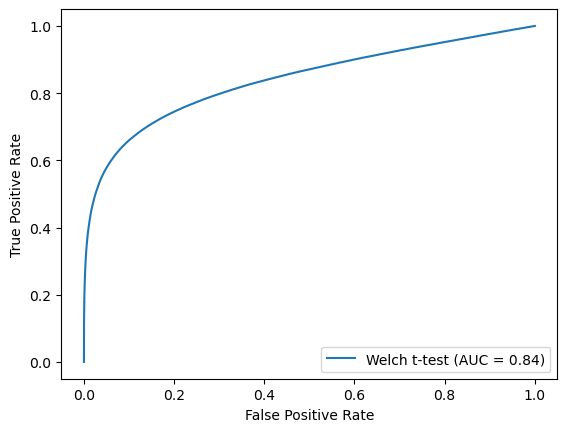

In [15]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(target_series, welch_probabilities)
roc_auc = sklearn.metrics.auc(fpr, tpr)
display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Welch t-test')
display.plot()

# Various utility functions

In [16]:
def display_awards(scores, award_recipient):
    print("Mean accuracy:", scores['test_accuracy'].mean())
    print("Mean type 1 error:", abs(scores['test_type_1_error_ratio'].mean()))
    print("Mean ROC AUC score:", scores['test_roc_auc'].mean())
    if (abs(scores['test_type_1_error_ratio'].mean()) < 0.05 and scores['test_accuracy'].mean() > welch_accuracy):
        print(f"{award_recipient} beat the Welch t-test while maintaining a low type 1 error ratio")
    if abs(scores['test_type_1_error_ratio'].mean()) < welch_type_1_error_ratio:
        print(f"{award_recipient} beat the Welch t-test on type 1 errors")
    if (abs(scores['test_type_1_error_ratio'].mean()) < welch_type_1_error_ratio 
        and 
        scores['test_accuracy'].mean() > welch_accuracy):
        print(f"WE HAVE A WINNER!!!!\n{award_recipient} beat the Welch t-test on type 1 errors AND on accuracy")
    if scores['test_roc_auc'].mean() > welch_roc:
        print(f"{award_recipient} beat Welch on ROC AUC")

In [17]:
def measure_sklearn(model, title, columns_to_use=None):
    if columns_to_use is None:
        columns_to_use = feature_dataframe.columns
    scores = sklearn.model_selection.cross_validate(model, 
                                       feature_dataframe[columns_to_use],
                                       target_series,
                                       scoring={'accuracy': 'accuracy', 
                                                'type_1_error_ratio': type_1_error_score,
                                               'roc_auc': 'roc_auc'}
                                      )
    display_awards(scores, title)
    return scores

## Various stupid ways to fail to beat it

Dummy gives us a baseline to be sure that the real models aren't just predicting the most common case.

In [18]:
dummy_scores = measure_sklearn(sklearn.dummy.DummyClassifier(strategy='most_frequent'), "Dummy")

Mean accuracy: 0.661209
Mean type 1 error: 0.0
Mean ROC AUC score: 0.5
Dummy beat the Welch t-test on type 1 errors


# Random forest using the original measurements

It seems to beat Welch if there is enough training data.

In [19]:
%%time
rfc_classic_scores = measure_sklearn(sklearn.ensemble.RandomForestClassifier(), 
                                     "Random forest using original measurements",
                                    classic_columns)

Mean accuracy: 0.8605579999999999
Mean type 1 error: 0.038031999999999996
Mean ROC AUC score: 0.8974759518606398
Random forest using original measurements beat the Welch t-test while maintaining a low type 1 error ratio
Random forest using original measurements beat Welch on ROC AUC
CPU times: user 33min 50s, sys: 6.96 s, total: 33min 57s
Wall time: 34min


# Random forest using synthesised differences

It seems to beat Welch if there is enough training data.

In [20]:
%%time
rfc_synthesised_scores = measure_sklearn(sklearn.ensemble.RandomForestClassifier(), 
                                     "Random forest using synthetic measurements",
                                    synthesised_columns)

Mean accuracy: 0.8604240000000001
Mean type 1 error: 0.038327999999999994
Mean ROC AUC score: 0.8967805881597958
Random forest using synthetic measurements beat the Welch t-test while maintaining a low type 1 error ratio
Random forest using synthetic measurements beat Welch on ROC AUC
CPU times: user 54min 43s, sys: 7.77 s, total: 54min 51s
Wall time: 55min 2s


# Neighbour methods

In [21]:
%%time
knn_classic_scores = measure_sklearn(sklearn.neighbors.KNeighborsClassifier(), 'KNeighbours', classic_columns)

Mean accuracy: 0.845391
Mean type 1 error: 0.05423300000000001
Mean ROC AUC score: 0.8649647941904639
KNeighbours beat Welch on ROC AUC
CPU times: user 6min 4s, sys: 300 ms, total: 6min 5s
Wall time: 6min 5s


In [22]:
%%time
knn_synth_scores = measure_sklearn(sklearn.neighbors.KNeighborsClassifier(), 'KNeighbours', synthesised_columns)

Mean accuracy: 0.8455
Mean type 1 error: 0.054122
Mean ROC AUC score: 0.8650415919960117
KNeighbours beat Welch on ROC AUC
CPU times: user 2h 21min 23s, sys: 25.3 s, total: 2h 21min 48s
Wall time: 18min 58s


# Neural networks

In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)

import numpy as np
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
%%time
inputs = feature_dataframe.to_numpy(dtype=float)
targets = target_series.to_numpy(dtype=float)
max_epochs = 300
hidden_size = 20
batch_size = 512
nn_scores = []
type_1_errors = []
accuracies = []
roc_scores = []
for fold, content in enumerate(kfold.split(inputs,targets)):
    train, test = content
    print("Fold", fold)

    model = models.Sequential()
    model.add(layers.Dense(hidden_size, activation='relu',input_shape=(feature_dataframe.shape[1],)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
    history = model.fit(inputs[train], targets[train],
                    epochs=max_epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[earlystopping],
                    verbose=0)
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    predictions = model.predict(inputs[test])[:,0] >= 0.5 # Predict 1 if the probability is >= 0.5
    type_1_error = type_1_error_ratio(targets[test], predictions)
    prediction_probabilies = model.predict(inputs[test])[:,0]
    roc_score = sklearn.metrics.roc_auc_score(targets[test], prediction_probabilies)
    print("After %i epochs out of %i" % (len(history.history['accuracy']), max_epochs))
    print("%s of fold %i: %f" % (model.metrics_names[0], fold, scores[0]))
    print("%s of fold %i: %f" % (model.metrics_names[1], fold, scores[1]))
    print("Type 1 error ratio of fold %i: %f" % (fold, type_1_error))
    print()
    accuracies.append(scores[1])
    type_1_errors.append(type_1_error)
    roc_scores.append(roc_score)
nn_scores = {
    'test_accuracy': numpy.array(accuracies),
    'test_type_1_error_ratio': numpy.array(type_1_errors),
    'test_roc_auc': numpy.array(roc_scores)
}
display_awards(nn_scores, f"Neural network with {hidden_size} hidden neurons")

Fold 0
Metal device set to: Apple M1


2023-09-13 00:21:24.345732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-13 00:21:24.346206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-13 00:21:24.974060: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-13 00:21:25.129375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 00:21:29.688767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 121/6250 [..............................] - ETA: 7s

2023-09-13 00:23:19.283067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 9s 1ms/step
After 18 epochs out of 300
loss of fold 0: 0.337019
accuracy of fold 0: 0.864190
Type 1 error ratio of fold 0: 0.040155

Fold 1


2023-09-13 00:23:41.620892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 00:23:46.142612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 124/6250 [..............................] - ETA: 7s

2023-09-13 00:26:05.676410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 8s 1ms/step
After 23 epochs out of 300
loss of fold 1: 0.341523
accuracy of fold 1: 0.861830
Type 1 error ratio of fold 1: 0.034255

Fold 2


2023-09-13 00:26:22.508783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 00:26:26.944752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 121/6250 [..............................] - ETA: 7s

2023-09-13 00:27:37.545715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 8s 1ms/step
After 11 epochs out of 300
loss of fold 2: 0.341879
accuracy of fold 2: 0.861180
Type 1 error ratio of fold 2: 0.035530

Fold 3


2023-09-13 00:27:54.136408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 00:27:58.703349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 126/6250 [..............................] - ETA: 7s

2023-09-13 00:29:50.200971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 8s 1ms/step
After 19 epochs out of 300
loss of fold 3: 0.340281
accuracy of fold 3: 0.862155
Type 1 error ratio of fold 3: 0.041750

Fold 4


2023-09-13 00:30:06.965728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-13 00:30:11.390154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 124/6250 [..............................] - ETA: 7s

2023-09-13 00:31:27.329989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 8s 1ms/step
After 12 epochs out of 300
loss of fold 4: 0.338736
accuracy of fold 4: 0.863675
Type 1 error ratio of fold 4: 0.035265

Mean accuracy: 0.8626060009002685
Mean type 1 error: 0.037391
Mean ROC AUC score: 0.9035928489283691
Neural network with 20 hidden neurons beat the Welch t-test while maintaining a low type 1 error ratio
Neural network with 20 hidden neurons beat Welch on ROC AUC
CPU times: user 8min 39s, sys: 2min 33s, total: 11min 12s
Wall time: 10min 19s


# Linear polyterms

No, you didn't see this. No good can possibly come of it.

In [25]:
import sklearn.pipeline
import sklearn.preprocessing

pipeline = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.PolynomialFeatures(include_bias=False),
    sklearn.linear_model.LogisticRegression(max_iter=100000, C=1e12)
)

In [26]:
%%time
logreg_poly_scores = measure_sklearn(pipeline, 'LinearPoly', synthesised_columns)

Mean accuracy: 0.855793
Mean type 1 error: 0.03447100000000001
Mean ROC AUC score: 0.8918289606310641
LinearPoly beat the Welch t-test while maintaining a low type 1 error ratio
LinearPoly beat Welch on ROC AUC
CPU times: user 3h 40min 2s, sys: 5min 42s, total: 3h 45min 45s
Wall time: 30min 59s


In [27]:
%%time
pipeline.fit(feature_dataframe[synthesised_columns], target_series)

CPU times: user 31min 52s, sys: 2min 17s, total: 34min 10s
Wall time: 5min 1s


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('logisticregression',
                 LogisticRegression(C=1000000000000.0, max_iter=100000))])

In [28]:
pipeline.named_steps['logisticregression'].intercept_

array([-0.00651025])

In [29]:
strengths = pandas.Series(index=pipeline.named_steps['polynomialfeatures'].get_feature_names_out(),
                          data=pipeline.named_steps['logisticregression'].coef_[0])
strengths

t_c0x0          -0.001188
t_c1x0          -0.005108
t_c2x0          -0.007726
t_c3x0          -0.010323
t_c4x0          -0.013874
                   ...   
t_c2x5 t_c3x5    0.000561
t_c2x5 t_c4x5    0.004595
t_c3x5^2        -0.003753
t_c3x5 t_c4x5    0.001273
t_c4x5^2        -0.008130
Length: 495, dtype: float64

<AxesSubplot: xlabel='v2', ylabel='v1'>

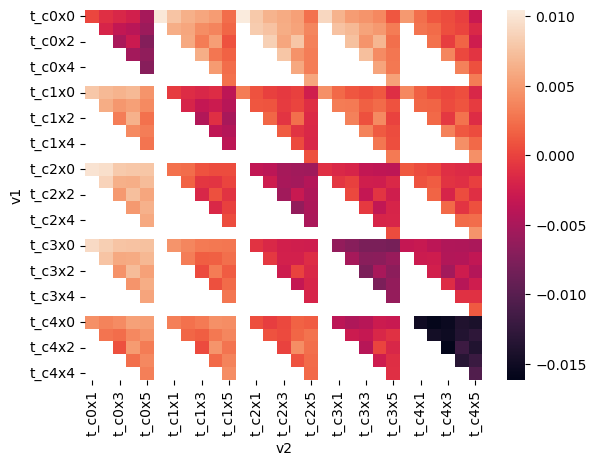

In [30]:
cross_term_strengths = strengths[strengths.index.str.contains(' ')
                                ].reset_index().rename(columns={'index': 'vars', 0: 'strength'})
cross_term_strengths['var_split'] = cross_term_strengths.vars.str.split(' ')
cross_term_strengths['v1'] = cross_term_strengths.var_split.map(lambda x: x[0])
cross_term_strengths['v2'] = cross_term_strengths.var_split.map(lambda x: x[1])
cross_term_strengths.drop('var_split', axis=1, inplace=True)
cross_term_strengths.drop('vars', axis=1, inplace=True)
cross_term_table = cross_term_strengths.pivot_table(
    index='v1',
    columns='v2',
    values='strength',
    #fill_value=0
)
import seaborn
seaborn.heatmap(cross_term_table)

<AxesSubplot: xlabel='experimentvar', ylabel='controlvar'>

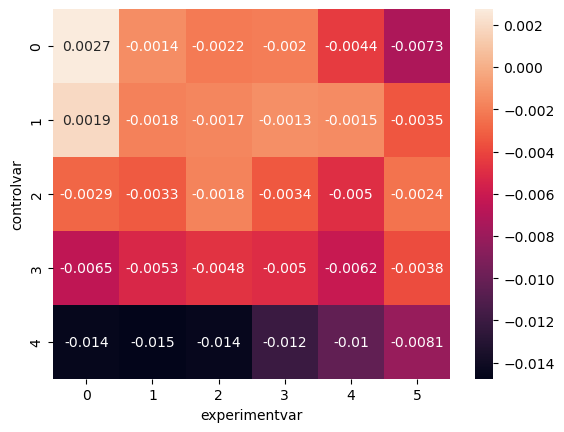

In [31]:
square_term_strengths = strengths[strengths.index.str.contains('^2', regex=False)
                                 ].reset_index().rename(columns={'index': 'varname',
                                                                0: 'strength'})
square_term_strengths['controlvar'] = square_term_strengths.varname.str.extract('t_c([0-9]+).*')
square_term_strengths['experimentvar'] = square_term_strengths.varname.str.extract('x([0-9]+)')
square_term_table = square_term_strengths.pivot_table(
    index='controlvar',
    columns='experimentvar',
    values='strength'
)
seaborn.heatmap(square_term_table, annot=True)

<AxesSubplot: xlabel='experimentvar', ylabel='controlvar'>

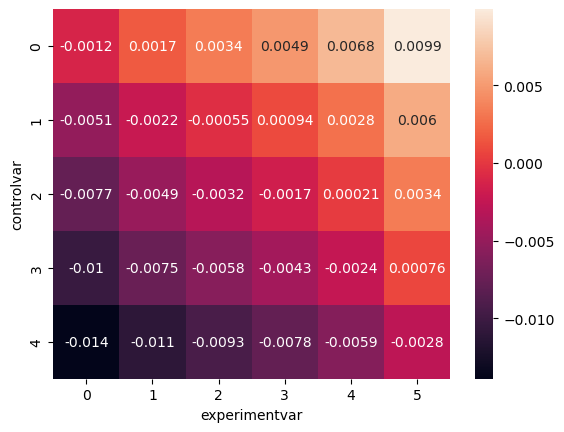

In [32]:
monoterm_strengths = strengths[~strengths.index.str.contains('^2', regex=False) & ~strengths.index.str.contains(' ')
                              ].reset_index().rename(columns={'index': 'varname',
                                                                0: 'strength'})
monoterm_strengths['controlvar'] = monoterm_strengths.varname.str.extract('t_c([0-9]+).*')
monoterm_strengths['experimentvar'] = monoterm_strengths.varname.str.extract('x([0-9]+)')
monoterm_table = monoterm_strengths.pivot_table(
    index='controlvar',
    columns='experimentvar',
    values='strength'
)
seaborn.heatmap(monoterm_table, annot=True)

<AxesSubplot: xlabel='strength', ylabel='Count'>

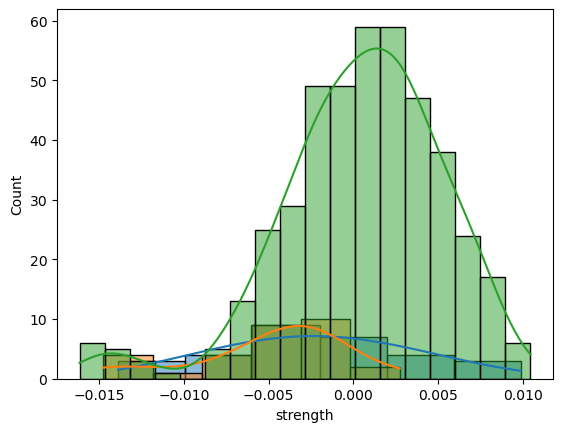

In [33]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots()
seaborn.histplot(monoterm_strengths.strength, ax=ax, kde=True, label="Mono terms")
seaborn.histplot(square_term_strengths.strength, ax=ax, kde=True, label="Square terms")
seaborn.histplot(cross_term_strengths.strength, ax=ax, kde=True, label="Cross terms")

#monoterm_strengths.plot.hist(ax=ax)